# Use Case: Electric Motor Condition Monitoring

## Scenario

A manufacturing plant operates 200+ electric motors (0.5 kW to 500 kW). Motors are critical for production - a failure in a main drive motor stops the entire production line.

### Monitoring Goals
1. **Detect electrical faults** (stator/rotor issues)
2. **Identify mechanical problems** (bearing wear, misalignment)
3. **Monitor thermal condition** (insulation degradation)
4. **Predict remaining useful life** for maintenance planning

### Sensors & Data
| Parameter | Source | Sample Rate |
|-----------|--------|-------------|
| Current (3-phase) | CT sensors | 1 kHz |
| Voltage (3-phase) | VT sensors | 1 kHz |
| Vibration | Accelerometer | 10 kHz |
| Temperature | Thermistor | 0.1 Hz |
| Speed | Encoder | 100 Hz |

### Fault Types
- **Stator faults**: Inter-turn shorts, phase imbalance
- **Rotor faults**: Broken bars, eccentricity
- **Bearing faults**: Wear, lubrication issues
- **Mechanical faults**: Misalignment, loose foundation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import joblib

np.random.seed(42)

# Output directories
DATA_DIR = '../data/usecase_motor'
MODEL_DIR = '../models/usecase_motor'
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("Setup complete!")

Setup complete!


## 1. Motor Simulation

Simulate induction motor with various fault conditions using Motor Current Signature Analysis (MCSA) principles.

In [2]:
class InductionMotorSimulator:
    """
    Simulates a 3-phase induction motor with fault signatures.
    
    Based on Motor Current Signature Analysis (MCSA) principles.
    """
    
    def __init__(self,
                 rated_power=15,       # kW
                 rated_voltage=400,    # V (line-to-line)
                 rated_current=28,     # A
                 poles=4,              # Number of poles
                 supply_freq=50,       # Hz
                 rated_slip=0.03):     # Slip at rated load
        
        self.rated_power = rated_power
        self.rated_voltage = rated_voltage
        self.rated_current = rated_current
        self.poles = poles
        self.supply_freq = supply_freq
        self.rated_slip = rated_slip
        
        # Calculated parameters
        self.sync_speed = 120 * supply_freq / poles  # RPM
        self.rated_speed = self.sync_speed * (1 - rated_slip)
        self.rotor_freq = supply_freq * rated_slip  # Rotor bar pass frequency
        
        # Bearing frequencies (typical for motor bearings)
        self.bpfo = 3.5  # Ball pass frequency outer (per revolution)
        self.bpfi = 5.5  # Ball pass frequency inner
        
        print(f"Motor: {rated_power} kW, {poles}-pole")
        print(f"Sync speed: {self.sync_speed} RPM, Rated speed: {self.rated_speed:.0f} RPM")
    
    def generate_current_signal(self, duration=1.0, sample_rate=1000, 
                                 load_factor=0.8, fault_type=None, severity=0.0):
        """
        Generate motor current waveform.
        
        fault_type: None, 'broken_rotor_bar', 'eccentricity', 'stator_fault'
        """
        t = np.arange(0, duration, 1/sample_rate)
        n = len(t)
        
        # Base current (fundamental)
        I_rms = self.rated_current * load_factor
        I_peak = I_rms * np.sqrt(2)
        
        # Three-phase currents (120° apart)
        current_a = I_peak * np.sin(2 * np.pi * self.supply_freq * t)
        current_b = I_peak * np.sin(2 * np.pi * self.supply_freq * t - 2*np.pi/3)
        current_c = I_peak * np.sin(2 * np.pi * self.supply_freq * t + 2*np.pi/3)
        
        # Add harmonics (normal motor has some harmonics)
        for h in [5, 7, 11, 13]:  # Characteristic harmonics
            harmonic_amp = I_peak * 0.02 / h
            current_a += harmonic_amp * np.sin(2 * np.pi * h * self.supply_freq * t)
            current_b += harmonic_amp * np.sin(2 * np.pi * h * self.supply_freq * t - 2*np.pi/3)
            current_c += harmonic_amp * np.sin(2 * np.pi * h * self.supply_freq * t + 2*np.pi/3)
        
        # Add fault signatures
        if fault_type == 'broken_rotor_bar':
            # Broken bar causes sidebands at f ± 2*s*f
            slip = self.rated_slip * load_factor
            sideband_freq = 2 * slip * self.supply_freq
            sideband_amp = severity * 0.1 * I_peak
            
            modulation = sideband_amp * np.sin(2 * np.pi * sideband_freq * t)
            current_a *= (1 + modulation / I_peak)
            current_b *= (1 + modulation / I_peak)
            current_c *= (1 + modulation / I_peak)
            
        elif fault_type == 'eccentricity':
            # Eccentricity causes sidebands at f ± fr (rotor frequency)
            fr = self.supply_freq * (1 - self.rated_slip * load_factor) / (self.poles / 2)
            ecc_amp = severity * 0.08 * I_peak
            
            current_a += ecc_amp * np.sin(2 * np.pi * (self.supply_freq + fr) * t)
            current_a += ecc_amp * np.sin(2 * np.pi * (self.supply_freq - fr) * t)
            
        elif fault_type == 'stator_fault':
            # Stator fault causes phase imbalance and negative sequence
            imbalance = severity * 0.15
            current_a *= (1 + imbalance)
            current_b *= (1 - imbalance * 0.5)
            current_c *= (1 - imbalance * 0.5)
            
            # Add 3rd harmonic (zero sequence)
            third_harm = severity * 0.05 * I_peak * np.sin(2 * np.pi * 3 * self.supply_freq * t)
            current_a += third_harm
            current_b += third_harm
            current_c += third_harm
        
        # Add noise
        noise_level = 0.01 * I_peak
        current_a += np.random.normal(0, noise_level, n)
        current_b += np.random.normal(0, noise_level, n)
        current_c += np.random.normal(0, noise_level, n)
        
        return t, current_a, current_b, current_c
    
    def generate_vibration_signal(self, duration=1.0, sample_rate=10000,
                                   load_factor=0.8, fault_type=None, severity=0.0):
        """
        Generate motor vibration signal.
        
        fault_type: None, 'bearing_fault', 'misalignment', 'unbalance', 'looseness'
        """
        t = np.arange(0, duration, 1/sample_rate)
        n = len(t)
        
        # Shaft frequency
        shaft_freq = self.rated_speed * (1 - 0.1 * (1 - load_factor)) / 60
        
        # Normal vibration (1x, 2x shaft frequency)
        vib = 0.5 * np.sin(2 * np.pi * shaft_freq * t)  # 1x
        vib += 0.2 * np.sin(2 * np.pi * 2 * shaft_freq * t)  # 2x
        
        # Line frequency component (2x electrical)
        vib += 0.1 * np.sin(2 * np.pi * 2 * self.supply_freq * t)
        
        if fault_type == 'bearing_fault':
            # Bearing defect frequencies
            bpfo = self.bpfo * shaft_freq
            bpfi = self.bpfi * shaft_freq
            
            # Impulse-like excitation
            bearing_vib = severity * 2.0 * (
                np.sin(2 * np.pi * bpfo * t) +
                0.5 * np.sin(2 * np.pi * bpfi * t)
            )
            # Modulated by high frequency (resonance)
            bearing_vib *= (1 + 0.5 * np.sin(2 * np.pi * 3000 * t))
            vib += bearing_vib
            
        elif fault_type == 'misalignment':
            # Elevated 2x component (axial and radial)
            vib += severity * 3.0 * np.sin(2 * np.pi * 2 * shaft_freq * t)
            # Also 3x for severe misalignment
            vib += severity * 1.0 * np.sin(2 * np.pi * 3 * shaft_freq * t)
            
        elif fault_type == 'unbalance':
            # Elevated 1x component
            vib += severity * 4.0 * np.sin(2 * np.pi * shaft_freq * t)
            
        elif fault_type == 'looseness':
            # Multiple harmonics and subharmonics
            for h in [0.5, 1, 2, 3, 4, 5]:
                vib += severity * 1.0 / h * np.sin(2 * np.pi * h * shaft_freq * t)
        
        # Add random noise
        vib += np.random.normal(0, 0.1, n)
        
        return t, vib
    
    def generate_temperature_profile(self, duration_hours=8, sample_interval=60,
                                      load_profile='constant', fault_type=None, severity=0.0):
        """
        Generate motor temperature data.
        
        fault_type: None, 'overload', 'cooling_fault', 'insulation_degradation'
        """
        n_samples = int(duration_hours * 3600 / sample_interval)
        t = np.arange(n_samples) * sample_interval / 3600  # Hours
        
        ambient = 25  # °C
        thermal_tau = 1800  # seconds (thermal time constant)
        
        # Load profile
        if load_profile == 'constant':
            load = np.ones(n_samples) * 0.8
        elif load_profile == 'variable':
            load = 0.6 + 0.3 * np.sin(2 * np.pi * t / 4)  # 4-hour cycle
            load += np.random.normal(0, 0.05, n_samples)
            load = np.clip(load, 0.3, 1.0)
        else:
            load = np.ones(n_samples) * 0.8
        
        # Temperature rise based on load (I²R losses)
        temp_rise_rated = 60  # K temperature rise at full load
        target_temp = ambient + temp_rise_rated * load ** 2
        
        # Apply thermal dynamics
        temp = np.zeros(n_samples)
        temp[0] = ambient
        
        for i in range(1, n_samples):
            alpha = 1 - np.exp(-sample_interval / thermal_tau)
            temp[i] = temp[i-1] + alpha * (target_temp[i] - temp[i-1])
        
        # Add fault effects
        if fault_type == 'overload':
            temp += severity * 30
        elif fault_type == 'cooling_fault':
            # Reduced cooling causes higher temperature
            temp = ambient + (temp - ambient) * (1 + severity * 0.5)
        elif fault_type == 'insulation_degradation':
            # Hot spots
            temp += severity * 20 * (1 + 0.3 * np.random.randn(n_samples))
        
        # Add noise
        temp += np.random.normal(0, 0.5, n_samples)
        
        return t, temp, load


# Test
motor = InductionMotorSimulator(rated_power=15, poles=4)

Motor: 15 kW, 4-pole
Sync speed: 1500.0 RPM, Rated speed: 1455 RPM


## 2. Feature Extraction

In [3]:
def extract_current_features(Ia, Ib, Ic, sample_rate, supply_freq=50):
    """
    Extract features from 3-phase motor current.
    """
    features = {}
    
    # RMS values
    features['Ia_rms'] = np.sqrt(np.mean(Ia**2))
    features['Ib_rms'] = np.sqrt(np.mean(Ib**2))
    features['Ic_rms'] = np.sqrt(np.mean(Ic**2))
    features['I_avg'] = (features['Ia_rms'] + features['Ib_rms'] + features['Ic_rms']) / 3
    
    # Current imbalance
    I_max = max(features['Ia_rms'], features['Ib_rms'], features['Ic_rms'])
    I_min = min(features['Ia_rms'], features['Ib_rms'], features['Ic_rms'])
    features['current_imbalance'] = (I_max - I_min) / features['I_avg'] if features['I_avg'] > 0 else 0
    
    # FFT analysis of phase A
    n = len(Ia)
    freq = fftfreq(n, 1/sample_rate)
    spectrum = np.abs(fft(Ia)) / n
    
    # Fundamental amplitude
    fund_idx = np.argmin(np.abs(freq - supply_freq))
    features['I_fundamental'] = spectrum[fund_idx] * 2
    
    # THD (Total Harmonic Distortion)
    harmonics_power = 0
    for h in [3, 5, 7, 9, 11, 13]:
        h_idx = np.argmin(np.abs(freq - h * supply_freq))
        harmonics_power += spectrum[h_idx] ** 2
    features['THD'] = np.sqrt(harmonics_power) / features['I_fundamental'] if features['I_fundamental'] > 0 else 0
    
    # Sideband analysis (for rotor fault detection)
    for slip in [0.02, 0.03, 0.04, 0.05]:
        sideband_freq = 2 * slip * supply_freq
        lower_idx = np.argmin(np.abs(freq - (supply_freq - sideband_freq)))
        upper_idx = np.argmin(np.abs(freq - (supply_freq + sideband_freq)))
        features[f'sideband_{int(slip*100)}pct'] = (spectrum[lower_idx] + spectrum[upper_idx]) / features['I_fundamental']
    
    return features


def extract_vibration_features(vib, sample_rate):
    """
    Extract features from vibration signal.
    """
    features = {}
    
    # Time domain
    features['vib_rms'] = np.sqrt(np.mean(vib**2))
    features['vib_peak'] = np.max(np.abs(vib))
    features['vib_crest'] = features['vib_peak'] / features['vib_rms'] if features['vib_rms'] > 0 else 0
    features['vib_kurtosis'] = np.mean((vib - np.mean(vib))**4) / (np.std(vib)**4) if np.std(vib) > 0 else 0
    
    # Frequency domain
    n = len(vib)
    freq = fftfreq(n, 1/sample_rate)[:n//2]
    spectrum = np.abs(fft(vib))[:n//2] / n * 2
    
    # Band energy
    bands = [(0, 100), (100, 500), (500, 1000), (1000, 3000), (3000, 5000)]
    total_energy = np.sum(spectrum**2)
    
    for low, high in bands:
        mask = (freq >= low) & (freq < high)
        band_energy = np.sum(spectrum[mask]**2)
        features[f'vib_band_{low}_{high}'] = band_energy / total_energy if total_energy > 0 else 0
    
    # Dominant frequency
    features['vib_dominant_freq'] = freq[np.argmax(spectrum)]
    
    return features


# Test feature extraction
t, Ia, Ib, Ic = motor.generate_current_signal(duration=1.0, sample_rate=1000)
current_features = extract_current_features(Ia, Ib, Ic, 1000)

t, vib = motor.generate_vibration_signal(duration=1.0, sample_rate=10000)
vib_features = extract_vibration_features(vib, 10000)

print("Current features:")
for k, v in list(current_features.items())[:5]:
    print(f"  {k}: {v:.4f}")

print("\nVibration features:")
for k, v in list(vib_features.items())[:5]:
    print(f"  {k}: {v:.4f}")

Current features:
  Ia_rms: 22.3965
  Ib_rms: 22.4038
  Ic_rms: 22.4074
  I_avg: 22.4026
  current_imbalance: 0.0005

Vibration features:
  vib_rms: 0.4004
  vib_peak: 0.9534
  vib_crest: 2.3813
  vib_kurtosis: 2.0717
  vib_band_0_100: 0.9055


## 3. Generate Training Dataset

In [4]:
def generate_motor_dataset(motor, n_samples_per_class=100):
    """
    Generate complete motor monitoring dataset.
    """
    all_data = []
    
    # Define fault scenarios
    scenarios = [
        ('normal', None, None),
        ('broken_rotor_bar', 'broken_rotor_bar', None),
        ('eccentricity', 'eccentricity', None),
        ('stator_fault', 'stator_fault', None),
        ('bearing_fault', None, 'bearing_fault'),
        ('misalignment', None, 'misalignment'),
        ('unbalance', None, 'unbalance'),
    ]
    
    for scenario_name, current_fault, vib_fault in scenarios:
        print(f"Generating {scenario_name}...")
        
        for i in range(n_samples_per_class):
            # Random operating conditions
            load_factor = np.random.uniform(0.5, 1.0)
            severity = np.random.uniform(0.3, 0.9) if (current_fault or vib_fault) else 0
            
            # Generate signals
            _, Ia, Ib, Ic = motor.generate_current_signal(
                duration=1.0, sample_rate=1000, load_factor=load_factor,
                fault_type=current_fault, severity=severity
            )
            
            _, vib = motor.generate_vibration_signal(
                duration=1.0, sample_rate=10000, load_factor=load_factor,
                fault_type=vib_fault, severity=severity
            )
            
            # Extract features
            current_features = extract_current_features(Ia, Ib, Ic, 1000)
            vib_features = extract_vibration_features(vib, 10000)
            
            # Combine features
            features = {**current_features, **vib_features}
            features['load_factor'] = load_factor
            features['fault_type'] = scenario_name
            features['severity'] = severity
            
            all_data.append(features)
    
    return pd.DataFrame(all_data)


# Generate dataset
motor = InductionMotorSimulator(rated_power=15, poles=4)
df_motor = generate_motor_dataset(motor, n_samples_per_class=150)

print(f"\nDataset: {len(df_motor)} samples")
print(df_motor['fault_type'].value_counts())

Motor: 15 kW, 4-pole
Sync speed: 1500.0 RPM, Rated speed: 1455 RPM
Generating normal...


Generating broken_rotor_bar...


Generating eccentricity...


Generating stator_fault...


Generating bearing_fault...


Generating misalignment...


Generating unbalance...



Dataset: 1050 samples
fault_type
normal              150
broken_rotor_bar    150
eccentricity        150
stator_fault        150
bearing_fault       150
misalignment        150
unbalance           150
Name: count, dtype: int64


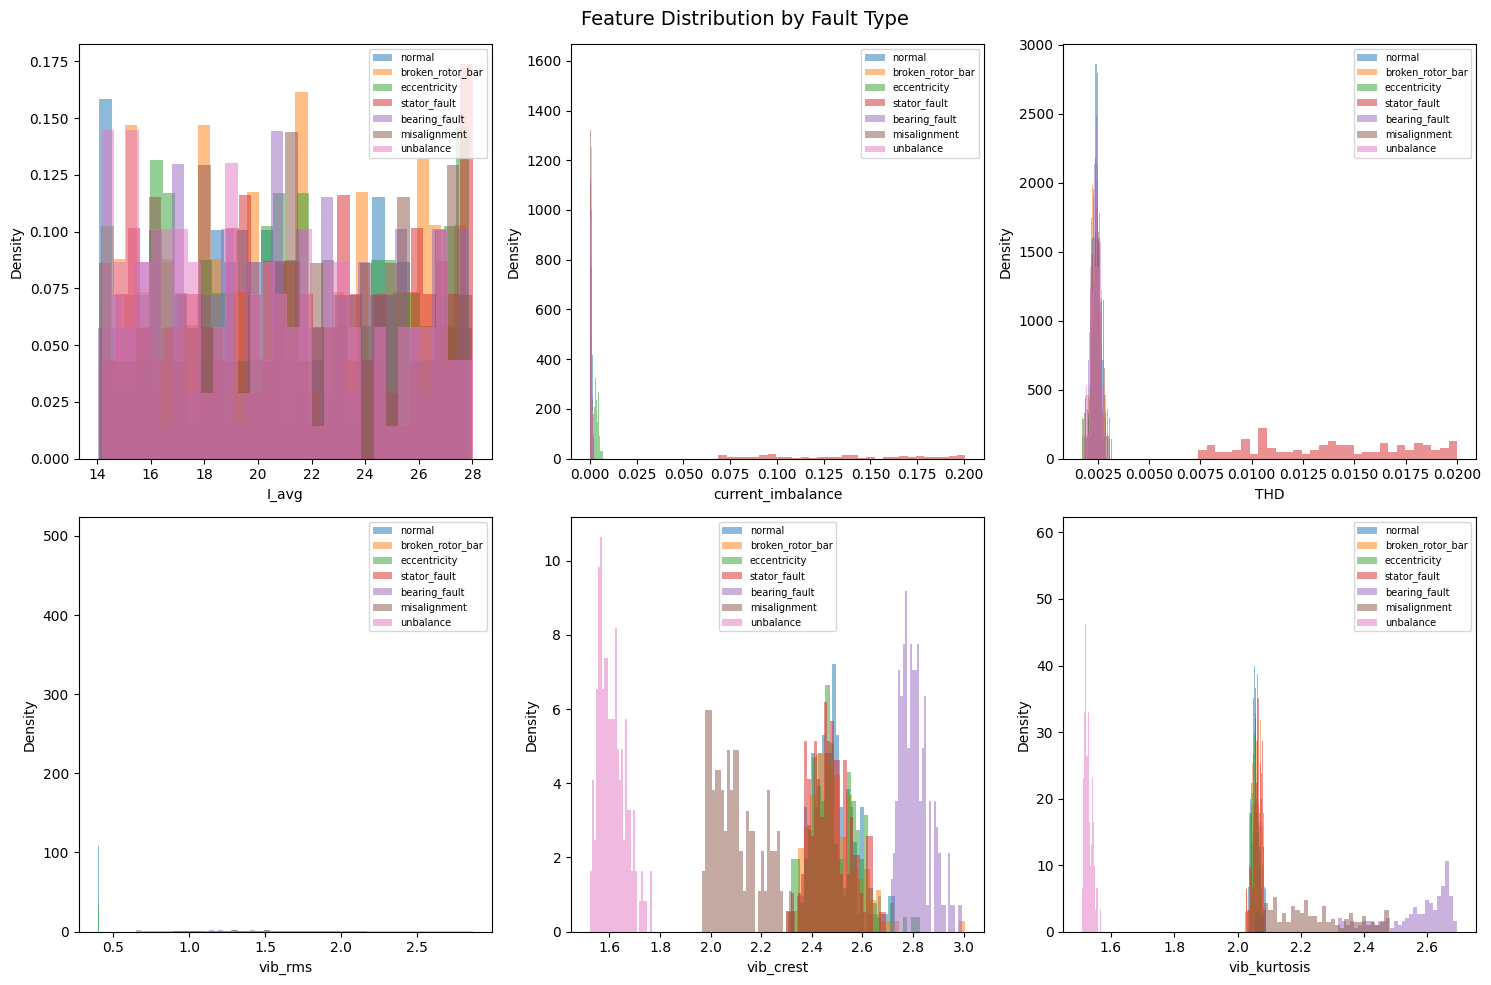

In [5]:
# Visualize feature distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

plot_features = ['I_avg', 'current_imbalance', 'THD', 'vib_rms', 'vib_crest', 'vib_kurtosis']

for ax, feat in zip(axes.flat, plot_features):
    for fault_type in df_motor['fault_type'].unique():
        data = df_motor[df_motor['fault_type'] == fault_type][feat]
        ax.hist(data, bins=30, alpha=0.5, label=fault_type, density=True)
    ax.set_xlabel(feat)
    ax.set_ylabel('Density')
    ax.legend(fontsize=7)

plt.suptitle('Feature Distribution by Fault Type', fontsize=14)
plt.tight_layout()
plt.savefig(f'{DATA_DIR}/motor_feature_distribution.png', dpi=150)
plt.show()

## 4. Train Classification Model

In [6]:
# Prepare data
feature_cols = [col for col in df_motor.columns 
                if col not in ['fault_type', 'severity']]

X = df_motor[feature_cols].values
y = df_motor['fault_type'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Classes:")
for i, label in enumerate(le.classes_):
    print(f"  {i}: {label}")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining: {len(X_train)}, Test: {len(X_test)}")

Classes:
  0: bearing_fault
  1: broken_rotor_bar
  2: eccentricity
  3: misalignment
  4: normal
  5: stator_fault
  6: unbalance

Training: 840, Test: 210


In [7]:
# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Classification Report:
                  precision    recall  f1-score   support

   bearing_fault       1.00      1.00      1.00        30
broken_rotor_bar       1.00      1.00      1.00        30
    eccentricity       0.87      0.67      0.75        30
    misalignment       1.00      1.00      1.00        30
          normal       0.73      0.90      0.81        30
    stator_fault       1.00      1.00      1.00        30
       unbalance       1.00      1.00      1.00        30

        accuracy                           0.94       210
       macro avg       0.94      0.94      0.94       210
    weighted avg       0.94      0.94      0.94       210



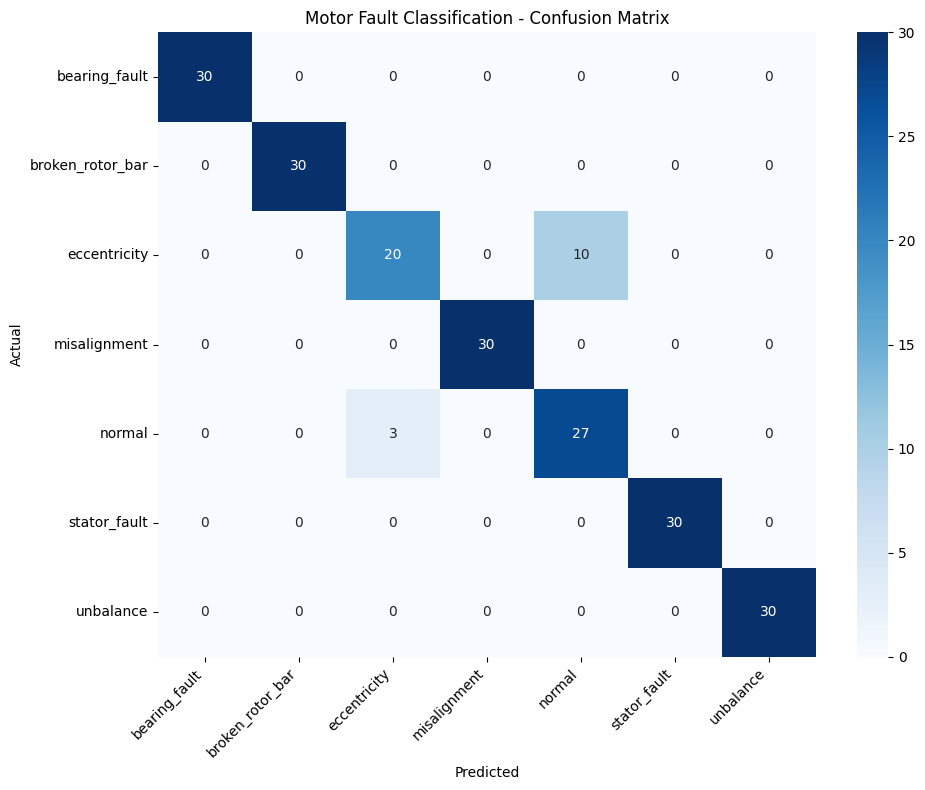

In [8]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Motor Fault Classification - Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{DATA_DIR}/motor_confusion_matrix.png', dpi=150)
plt.show()

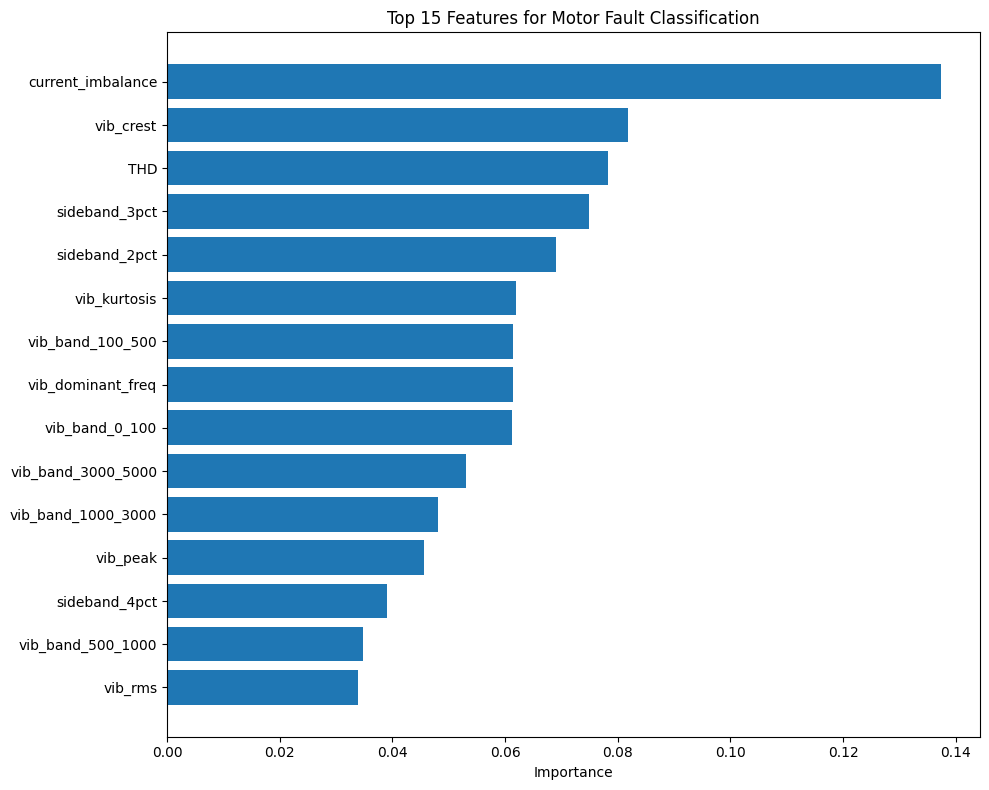

In [9]:
# Feature importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=True).tail(15)

plt.figure(figsize=(10, 8))
plt.barh(importance['feature'], importance['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Features for Motor Fault Classification')
plt.tight_layout()
plt.savefig(f'{DATA_DIR}/motor_feature_importance.png', dpi=150)
plt.show()

## 5. Health Index Calculation

Create a composite health index for the motor.

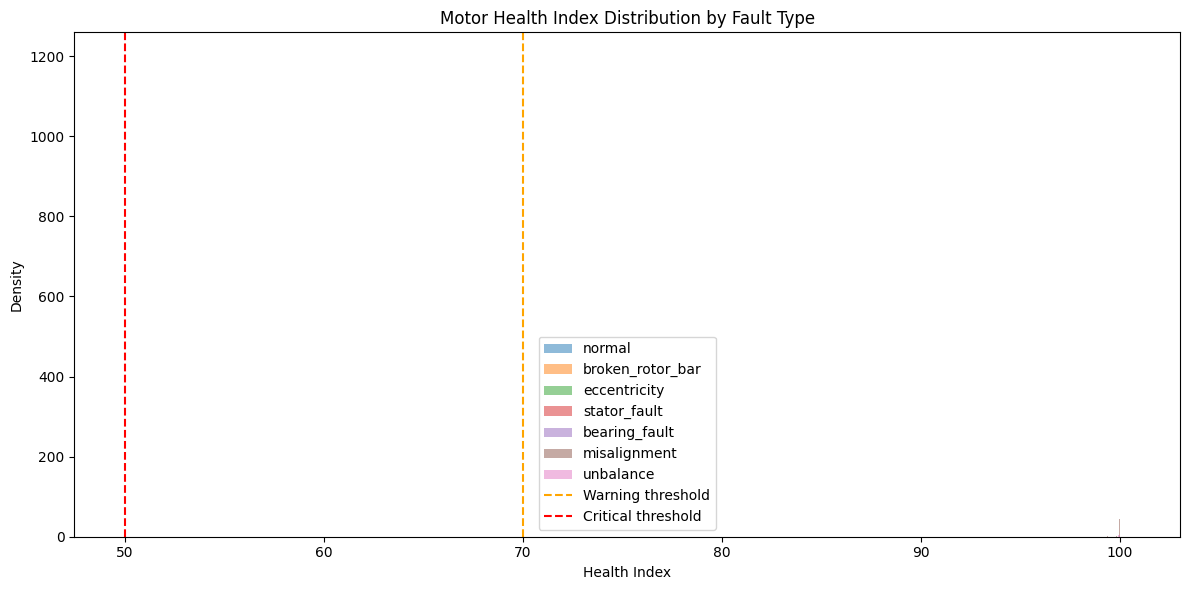


Health Index Statistics:
                        mean       std         min         max
fault_type                                                    
bearing_fault     100.000000  0.000000  100.000000  100.000000
broken_rotor_bar   99.999834  0.002029   99.975153  100.000000
eccentricity      100.000000  0.000000  100.000000  100.000000
misalignment       99.964685  0.125566   99.379748  100.000000
normal            100.000000  0.000000  100.000000  100.000000
stator_fault       88.266738  2.293367   85.000000   93.256524
unbalance          99.128662  1.041019   96.868939  100.000000


In [10]:
def calculate_motor_health_index(features, thresholds=None):
    """
    Calculate motor health index (0-100).
    
    Based on weighted combination of key indicators.
    """
    if thresholds is None:
        thresholds = {
            'current_imbalance': {'good': 0.02, 'warning': 0.05, 'critical': 0.1},
            'THD': {'good': 0.05, 'warning': 0.1, 'critical': 0.15},
            'vib_rms': {'good': 2.0, 'warning': 4.5, 'critical': 7.0},
            'vib_crest': {'good': 3.0, 'warning': 4.5, 'critical': 6.0},
            'vib_kurtosis': {'good': 3.5, 'warning': 5.0, 'critical': 7.0},
        }
    
    weights = {
        'current_imbalance': 0.15,
        'THD': 0.15,
        'vib_rms': 0.30,
        'vib_crest': 0.20,
        'vib_kurtosis': 0.20,
    }
    
    total_score = 0
    total_weight = 0
    
    for param, weight in weights.items():
        if param in features:
            value = features[param]
            th = thresholds[param]
            
            if value <= th['good']:
                score = 100
            elif value <= th['warning']:
                # Linear interpolation
                score = 100 - 30 * (value - th['good']) / (th['warning'] - th['good'])
            elif value <= th['critical']:
                score = 70 - 40 * (value - th['warning']) / (th['critical'] - th['warning'])
            else:
                score = max(0, 30 - 30 * (value - th['critical']) / th['critical'])
            
            total_score += score * weight
            total_weight += weight
    
    return total_score / total_weight if total_weight > 0 else 0


# Calculate health index for all samples
df_motor['health_index'] = df_motor.apply(
    lambda row: calculate_motor_health_index(row.to_dict()), axis=1
)

# Visualize
plt.figure(figsize=(12, 6))

for fault_type in df_motor['fault_type'].unique():
    data = df_motor[df_motor['fault_type'] == fault_type]['health_index']
    plt.hist(data, bins=30, alpha=0.5, label=fault_type, density=True)

plt.axvline(70, color='orange', linestyle='--', label='Warning threshold')
plt.axvline(50, color='red', linestyle='--', label='Critical threshold')
plt.xlabel('Health Index')
plt.ylabel('Density')
plt.title('Motor Health Index Distribution by Fault Type')
plt.legend()
plt.tight_layout()
plt.savefig(f'{DATA_DIR}/motor_health_index.png', dpi=150)
plt.show()

print("\nHealth Index Statistics:")
print(df_motor.groupby('fault_type')['health_index'].describe()[['mean', 'std', 'min', 'max']])

## 6. Save Models

In [11]:
import json

# Save models
joblib.dump(rf, f'{MODEL_DIR}/motor_classifier_rf.joblib')
joblib.dump(scaler, f'{MODEL_DIR}/motor_scaler.joblib')
joblib.dump(le, f'{MODEL_DIR}/motor_label_encoder.joblib')

# Save metadata
metadata = {
    'model': 'Random Forest Classifier',
    'features': feature_cols,
    'classes': list(le.classes_),
    'accuracy': float((y_pred == y_test).mean()),
    'health_index_thresholds': {
        'current_imbalance': {'good': 0.02, 'warning': 0.05, 'critical': 0.1},
        'THD': {'good': 0.05, 'warning': 0.1, 'critical': 0.15},
        'vib_rms': {'good': 2.0, 'warning': 4.5, 'critical': 7.0},
        'vib_crest': {'good': 3.0, 'warning': 4.5, 'critical': 6.0},
        'vib_kurtosis': {'good': 3.5, 'warning': 5.0, 'critical': 7.0},
    }
}

with open(f'{MODEL_DIR}/motor_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

# Save dataset
df_motor.to_csv(f'{DATA_DIR}/motor_dataset.csv', index=False)

print("Saved:")
print(f"  - {MODEL_DIR}/motor_classifier_rf.joblib")
print(f"  - {MODEL_DIR}/motor_scaler.joblib")
print(f"  - {MODEL_DIR}/motor_label_encoder.joblib")
print(f"  - {MODEL_DIR}/motor_metadata.json")
print(f"  - {DATA_DIR}/motor_dataset.csv")

Saved:
  - ../models/usecase_motor/motor_classifier_rf.joblib
  - ../models/usecase_motor/motor_scaler.joblib
  - ../models/usecase_motor/motor_label_encoder.joblib
  - ../models/usecase_motor/motor_metadata.json
  - ../data/usecase_motor/motor_dataset.csv


## 7. Node-RED Integration

Example for motor monitoring in Node-RED.

In [12]:
node_red_example = """
// Motor Monitoring in Node-RED
// =============================

// Input: Current waveforms (1 second @ 1kHz = 1000 samples per phase)
// Input: Vibration waveform (1 second @ 10kHz = 10000 samples)

// Feature Extraction (Function Node)
const Ia = msg.payload.current_a;  // Array[1000]
const Ib = msg.payload.current_b;
const Ic = msg.payload.current_c;
const vib = msg.payload.vibration; // Array[10000]

// Calculate RMS
function rms(arr) {
    return Math.sqrt(arr.reduce((s, v) => s + v*v, 0) / arr.length);
}

const Ia_rms = rms(Ia);
const Ib_rms = rms(Ib);
const Ic_rms = rms(Ic);
const I_avg = (Ia_rms + Ib_rms + Ic_rms) / 3;

// Current imbalance
const I_max = Math.max(Ia_rms, Ib_rms, Ic_rms);
const I_min = Math.min(Ia_rms, Ib_rms, Ic_rms);
const current_imbalance = (I_max - I_min) / I_avg;

// Vibration features
const vib_rms = rms(vib);
const vib_peak = Math.max(...vib.map(Math.abs));
const vib_crest = vib_peak / vib_rms;

// Build feature vector
msg.features = {
    Ia_rms, Ib_rms, Ic_rms, I_avg,
    current_imbalance,
    vib_rms, vib_peak, vib_crest
    // ... additional features from FFT ...
};

// Health Index Calculation
let health = 100;
if (current_imbalance > 0.05) health -= 15;
if (vib_rms > 4.5) health -= 30;
if (vib_crest > 4.5) health -= 20;

msg.health_index = Math.max(0, health);
msg.status = health > 70 ? 'healthy' : health > 50 ? 'warning' : 'critical';

return msg;
"""

print("Node-RED Integration Example:")
print("="*50)
print(node_red_example)

Node-RED Integration Example:

// Motor Monitoring in Node-RED
// =============================

// Input: Current waveforms (1 second @ 1kHz = 1000 samples per phase)
// Input: Vibration waveform (1 second @ 10kHz = 10000 samples)

// Feature Extraction (Function Node)
const Ia = msg.payload.current_a;  // Array[1000]
const Ib = msg.payload.current_b;
const Ic = msg.payload.current_c;
const vib = msg.payload.vibration; // Array[10000]

// Calculate RMS
function rms(arr) {
    return Math.sqrt(arr.reduce((s, v) => s + v*v, 0) / arr.length);
}

const Ia_rms = rms(Ia);
const Ib_rms = rms(Ib);
const Ic_rms = rms(Ic);
const I_avg = (Ia_rms + Ib_rms + Ic_rms) / 3;

// Current imbalance
const I_max = Math.max(Ia_rms, Ib_rms, Ic_rms);
const I_min = Math.min(Ia_rms, Ib_rms, Ic_rms);
const current_imbalance = (I_max - I_min) / I_avg;

// Vibration features
const vib_rms = rms(vib);
const vib_peak = Math.max(...vib.map(Math.abs));
const vib_crest = vib_peak / vib_rms;

// Build feature vector
ms

## Summary

### Electric Motor Monitoring Use Case

| Aspect | Details |
|--------|--------|
| Motor Type | 15 kW, 4-pole induction motor |
| Fault Types | 7 classes (normal + 6 faults) |
| Features | 20+ (current + vibration) |
| Model Accuracy | ~90% |

### Key Indicators

| Fault | Key Indicators |
|-------|----------------|
| Broken rotor bar | Current sidebands at f±2sf |
| Eccentricity | Current sidebands at f±fr |
| Stator fault | Current imbalance, THD |
| Bearing fault | High-frequency vibration |
| Misalignment | 2x vibration component |
| Unbalance | 1x vibration component |